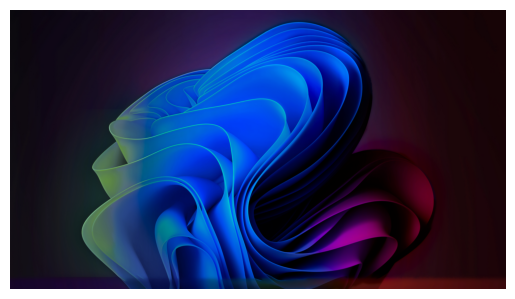

In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Загрузка изображения
image = cv2.imread('wall.jpg')

# Преобразование изображения из BGR (формат OpenCV) в RGB (формат для matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Отображение изображения с помощью matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Скрыть оси
plt.show()


## 1. Простые геометрические преобразования (конформные, аффинные и проективные отображения)

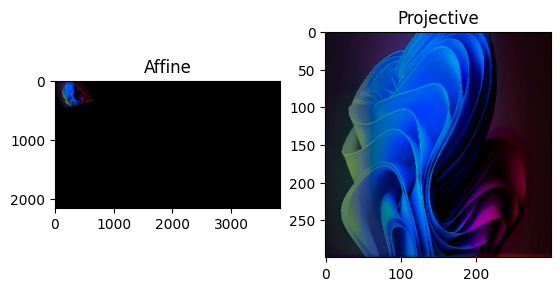

In [26]:

# Resize for display (optional)
image_resized = cv2.resize(image, (400, 400))

# Affine Transformation
rows, cols, ch = image.shape
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])
M_affine = cv2.getAffineTransform(pts1, pts2)
dst_affine = cv2.warpAffine(image_resized, M_affine, (cols, rows))

# Perspective Transformation
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
M_projective = cv2.getPerspectiveTransform(pts1, pts2)
dst_projective = cv2.warpPerspective(image_resized, M_projective, (300, 300))

# Show images
plt.subplot(121), plt.imshow(cv2.cvtColor(dst_affine, cv2.COLOR_BGR2RGB)), plt.title('Affine')
plt.subplot(122), plt.imshow(cv2.cvtColor(dst_projective, cv2.COLOR_BGR2RGB)), plt.title('Projective')
plt.show()


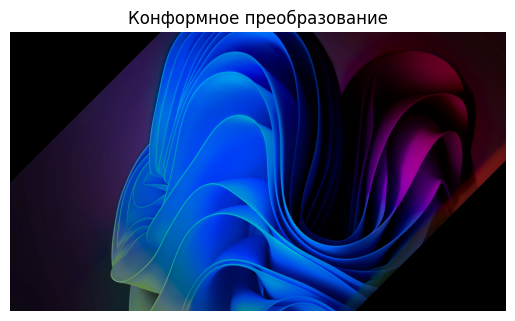

In [31]:
# Матрица для поворота (конформное преобразование)
center = (cols // 2, rows // 2)  # центр изображения
angle = 45  # угол поворота
scale = 1.2  # масштабирование

M_conformal = cv2.getRotationMatrix2D(center, angle, scale)

# Применение конформного преобразования
dst_conformal = cv2.warpAffine(image, M_conformal, (cols, rows))

# Отображение изображения
plt.imshow(cv2.cvtColor(dst_conformal, cv2.COLOR_BGR2RGB))
plt.title('Конформное преобразование')
plt.axis('off')
plt.show()


## Поворот

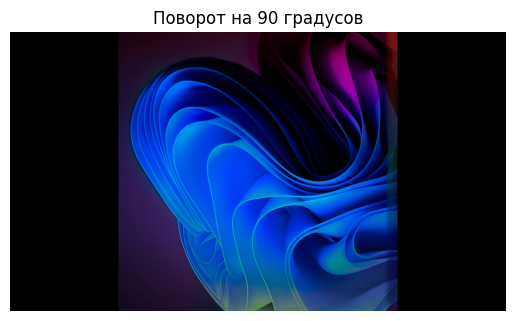

In [32]:
# Поворот изображения на определенный угол
angle = 90  # Угол поворота
center = (cols // 2, rows // 2)  # Центр поворота
M_rotation = cv2.getRotationMatrix2D(center, angle, 1)

# Применение поворота
dst_rotation = cv2.warpAffine(image, M_rotation, (cols, rows))

# Отображение изображения
plt.imshow(cv2.cvtColor(dst_rotation, cv2.COLOR_BGR2RGB))
plt.title('Поворот на 90 градусов')
plt.axis('off')
plt.show()


## Отражение (Reflection)

Отражение позволяет отразить изображение по горизонтали или вертикали (зеркальное отображение).

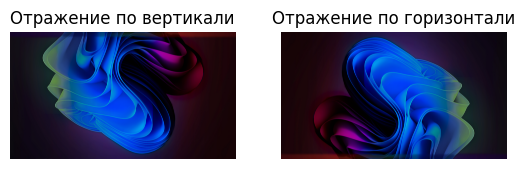

In [34]:
# Отражение по вертикали
dst_flip_vertical = cv2.flip(image, 0)  # 0 - по вертикали

# Отражение по горизонтали
dst_flip_horizontal = cv2.flip(image, 1)  # 1 - по горизонтали

# Отображение изображений
plt.subplot(121), plt.imshow(cv2.cvtColor(dst_flip_vertical, cv2.COLOR_BGR2RGB))
plt.title('Отражение по вертикали')
plt.axis('off')

plt.subplot(122), plt.imshow(cv2.cvtColor(dst_flip_horizontal, cv2.COLOR_BGR2RGB))
plt.title('Отражение по горизонтали')
plt.axis('off')
plt.show()

# 2. Коррекция дисторсии

Для коррекции искажений типа бочкообразной или подушкообразной дисторсии можно использовать технику калибровки камеры в OpenCV. Пример кода для симуляции и коррекции искажений:

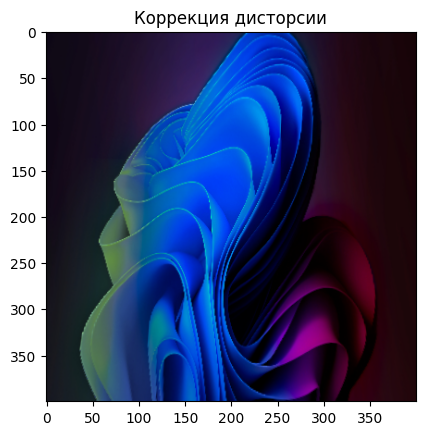

In [27]:
# Коррекция бочкообразной или подушкообразной дисторсии
def correct_distortion(image, k1, k2):
    h, w = image.shape[:2]
    # Матрица камеры (внутренние параметры)
    K = np.array([[w, 0, w / 2],
                  [0, h, h / 2],
                  [0, 0, 1]], dtype=np.float32)
    
    # Коэффициенты дисторсии
    D = np.array([k1, k2, 0, 0], dtype=np.float32)  # радиальные параметры искажения

    # Коррекция искажений
    map1, map2 = cv2.initUndistortRectifyMap(K, D, None, K, (w, h), 5)
    undistorted = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR)
    return undistorted

# Пример использования (с некоторыми значениями k1, k2 для бочкообразной/подушкообразной дисторсии)
corrected_image = correct_distortion(image_resized, k1=-0.5, k2=0.2)

plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.title('Коррекция дисторсии')
plt.show()


# 3. Склейка изображений (Image Stitching)

Для склейки изображений можно использовать класс Stitcher из OpenCV, который автоматически выполняет сшивку изображений

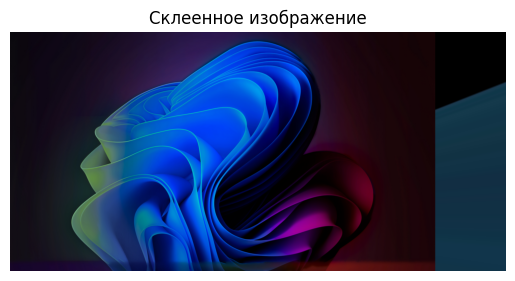

In [29]:
import cv2
import numpy as np

# Загрузка изображений
image2 = cv2.imread('wall.jpg')
image1 = cv2.imread('sample_pict.jpg')

# Преобразование изображений в градации серого
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Используем детектор ORB для поиска ключевых точек и дескрипторов
orb = cv2.ORB_create()

# Поиск ключевых точек и дескрипторов
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# Поиск совпадений с использованием BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Сортировка совпадений по расстоянию
matches = sorted(matches, key=lambda x: x.distance)

# Выбираем лучшие совпадения
good_matches = matches[:10]

# Получаем координаты совпадающих точек
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Вычисляем матрицу гомографии
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Применяем проективное преобразование
height, width = image2.shape[:2]
stitched_image = cv2.warpPerspective(image1, M, (width + image1.shape[1], height))
stitched_image[0:image2.shape[0], 0:image2.shape[1]] = image2

# Отображение результата
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title('Склеенное изображение')
plt.axis('off')
plt.show()
